**Корректность проверена на Python 3.6:**
+ numpy 1.15.4
+ matplotlib 3.0.2
+ pandas 0.23.4


# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [43]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк
df = pd.read_csv('https://stepik.org/media/attachments/lesson/85563/_1fbbe0f3404552777e1932b2a209e803_bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

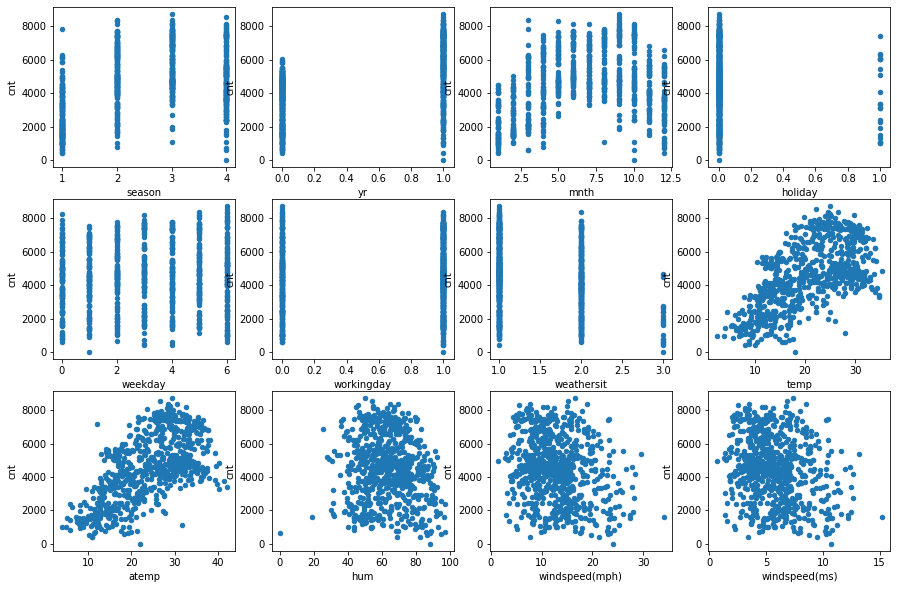

In [105]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: летом чаще берут велосипед в прокат, нежели в остальные сезоны. Это можно объяснить тем, что летом - тёплая и ясная погода - самое то, чтобы покататься на велосипеде. Наибольший спрос в сентябре. Я думаю, что это объясняется тем, что летом многие люди уезжают в отпуск, а к сентябрю большинство возращается + пока погода всё ещё хорошая, людям хочется немного ей понаслаждаться
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: Наиболее яркая зависимость видна между числом прокатов и температурой. Это логично, т.к. на велосипеде приятнее ездить в теплую погоду. Однако не стоит забывать, что при увеличении температуры, у нас, скорее всего начнётся спад количества прокатов. Вряд ли будет много желающих покататься в +50

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [350]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
df.drop('cnt', axis=1).corrwith(df.cnt)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [57]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
corr = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
corr

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


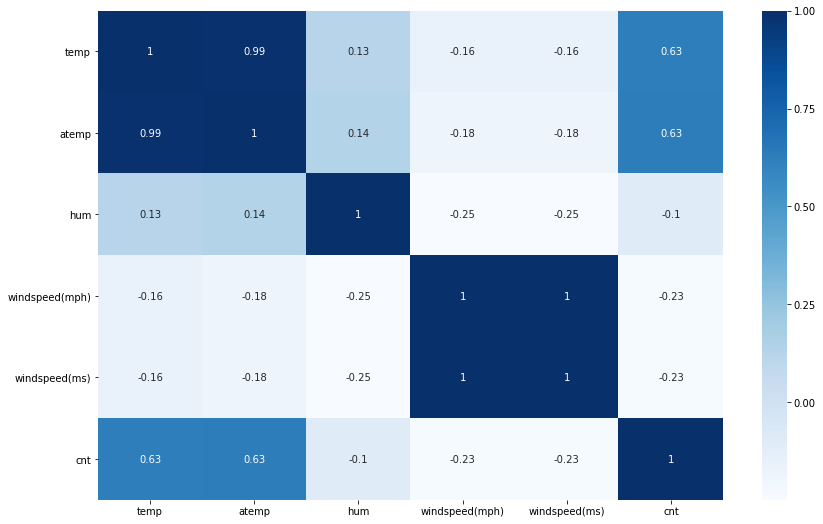

In [58]:
# Добавим немного визуализации, так будет нагляднее
import seaborn as sns

plt.figure(figsize=(14, 9))
sns.heatmap(corr, annot=True, cmap=plt.cm.Blues);

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [59]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [ ]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [60]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [65]:
from sklearn.linear_model import LinearRegression

In [100]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns

ref = LinearRegression()
ref.fit(X, y)

pd.DataFrame(zip(df.columns, ref.coef_))

,0,1
0,season,5.708700e+02
1,yr,1.021960e+03
2,mnth,-1.413000e+02
3,holiday,-8.676000e+01
4,weekday,1.372300e+02
5,workingday,5.639000e+01
6,weathersit,-3.302300e+02
7,temp,3.674700e+02
8,atemp,5.855600e+02
9,hum,-1.456100e+02


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [81]:
from sklearn.linear_model import Lasso, Ridge

In [98]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса
L1 = Lasso()
L1.fit(X, y)

pd.DataFrame(zip(df.columns, L1.coef_.round(2)))

,0,1
0,season,560.24
1,yr,1019.46
2,mnth,-128.73
3,holiday,-86.15
4,weekday,137.35
5,workingday,55.21
6,weathersit,-332.37
7,temp,376.36
8,atemp,576.53
9,hum,-144.13


In [99]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса
L2 = Ridge()
L2.fit(X, y)

pd.DataFrame(zip(df.columns, L2.coef_.round(2)))

,0,1
0,season,563.06
1,yr,1018.95
2,mnth,-131.87
3,holiday,-86.75
4,weekday,138.01
5,workingday,55.90
6,weathersit,-332.35
7,temp,386.46
8,atemp,566.35
9,hum,-145.07


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [136]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.
for i, a in enumerate(alphas):
    L1 = Lasso(alpha=a)
    L1.fit(X, y)
    coefs_lasso[i] = L1.coef_
    
    L2 = Ridge(alpha=a)
    L2.fit(X, y)
    coefs_ridge[i] = L2.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

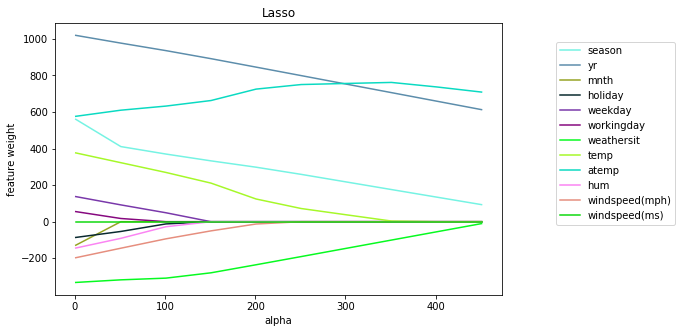

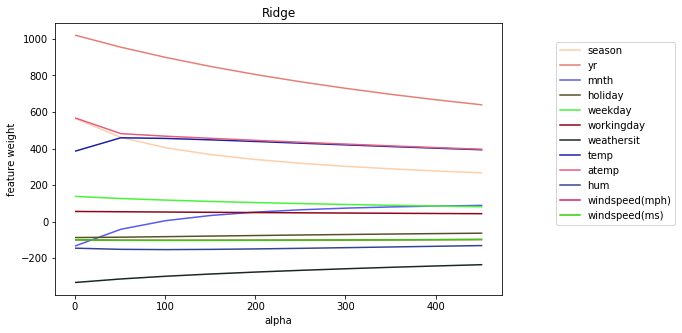

In [137]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")
plt.show()

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: по графику можно заметить, что регуляризатор Lasso агрессивнее уменьшает веса при одном и том же alpha. Поэтому если нам необходимо уменьшить количество признаков(обнулить веса), то, в первую очередь, мы должны рассматривать Lasso
2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: значение всех весов станет равным 0. Это происходит потому что при использовании регуляризации, мы штрафуем за ошибку и за большие веса. Альфа - это множитель перед весами, следовательно, если мы его увеличиваем, то алгоритму ничего не остаётся кроме того, как уменьшать веса, зануляя их. Сначала он зануляет веса у тех признаков, которые не сильно влияют на модель (т.е. среднеквадратическая ошибка не сильно увеличивается), затем у него не остаётся выбора и он зануляет веса у всех признаков. 
3. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ:  Lasso - да, Ridge - нет.
4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: Lasso. Объяснение смотреть во втором вопросе

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [138]:
from sklearn.linear_model import LassoCV

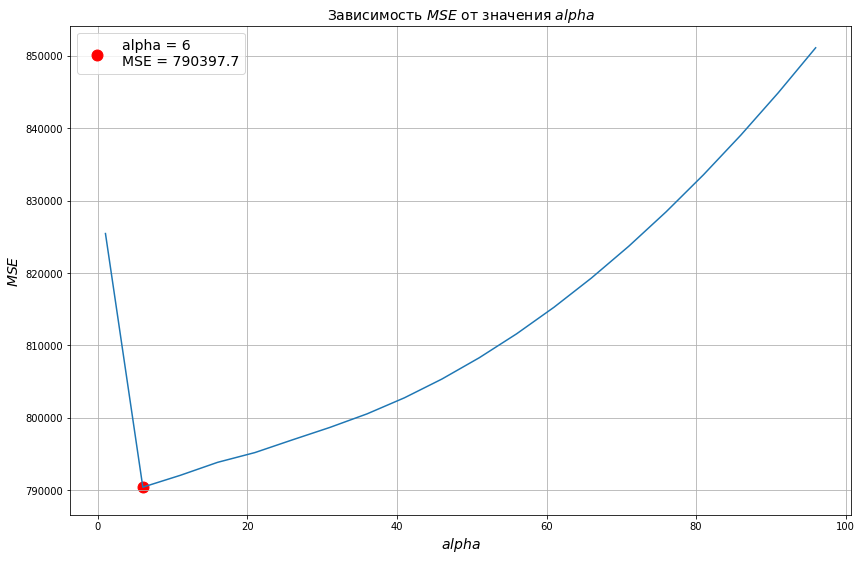

alpha = 6


,feature,weight
1,yr,1015.06
8,atemp,581.40
0,season,532.02
7,temp,370.68
4,weekday,132.50
5,workingday,51.56
11,windspeed(ms),-0.00
3,holiday,-83.29
2,mnth,-100.04
9,hum,-140.01


In [335]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)

reg = LassoCV(alphas=alphas, cv=3).fit(X, y) # Обучаем регрессор

plt.figure(figsize=(14,9))
plt.plot(reg.alphas_, reg.mse_path_.mean(axis=1))
plt.scatter(reg.alpha_, reg.mse_path_.mean(axis=1).min(), color='red', s=120, marker='o',
            label=(f'alpha = {reg.alpha_}\nMSE = {reg.mse_path_.mean(axis=1).min().round(1)}'))
plt.title('Зависимость $MSE$ от значения $alpha$', fontsize=14)
plt.xlabel('$alpha$', fontsize=14)
plt.ylabel('$MSE$', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

print(f'alpha = {reg.alpha_}') # Выведим выбранное alpha

# а также пары "признак-коэффициент" для обученного вектора коэффициентов:
last_model_weights = pd.DataFrame(reg.coef_.round(2), df.drop('cnt', axis=1).columns).reset_index()
last_model_weights.columns = ['feature', 'weight']
last_model_weights.sort_values(by='weight', ascending=False, inplace=True)
last_model_weights

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

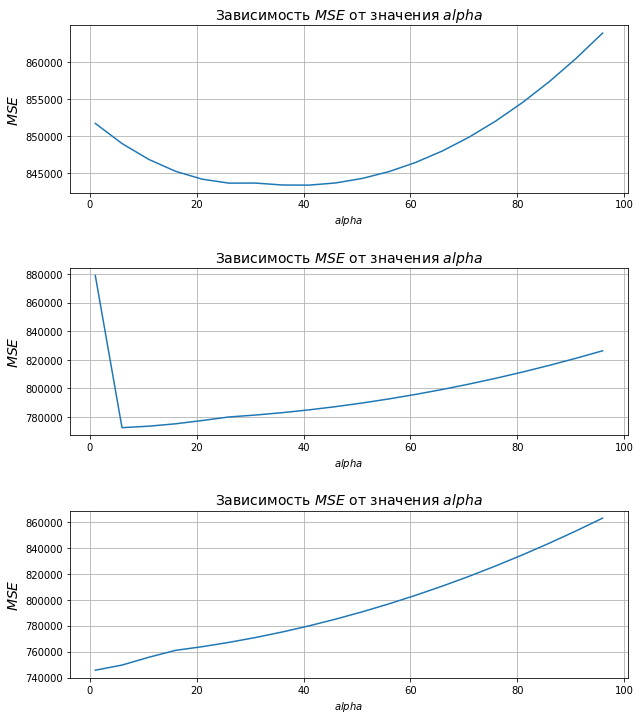

,alpha,min_MSE
0,96,826364.12
1,91,821110.18
2,86,816153.28
3,81,811496.35
4,76,807139.40
5,71,803082.42
6,66,799325.43
7,61,795868.41
8,56,792711.37
9,51,789854.31


In [327]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

for i in range(3):
    ax[i].plot(reg.alphas_, reg.mse_path_[:, i])
    ax[i].set_title('Зависимость $MSE$ от значения $alpha$', fontsize=14)
    ax[i].set_xlabel('$alpha$', fontsize=10)
    ax[i].set_ylabel('$MSE$', fontsize=14)
    ax[i].grid()
plt.subplots_adjust(wspace=0, hspace=0.45)
plt.show()

tmp2 = pd.DataFrame(reg.mse_path_.min(axis=1).round(2), reg.alphas_).reset_index()
tmp2.columns = ['alpha', 'min_MSE']
tmp2

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

In [349]:
print('4 признака с наибольшими (положительными) коэфициентами:')
print(last_model_weights.head(4))

print()
print('3 признака с наибольшими по модулю отрицательными коэффициентами:')
print(last_model_weights.tail(3))

print()
print('Признаки с коэффициентами, близкими к нулю (< 1e-3):')
print(last_model_weights[last_model_weights.weight.abs() < 1e-3])

4 признака с наибольшими (положительными) коэфициентами:
  feature   weight
1      yr  1015.06
8   atemp   581.40
0  season   532.02
7    temp   370.68

3 признака с наибольшими по модулю отрицательными коэффициентами:
           feature  weight
9              hum -140.01
10  windspeed(mph) -191.77
6       weathersit -330.56

Признаки с коэффициентами, близкими к нулю (< 1e-3):
          feature  weight
11  windspeed(ms)    -0.0


__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: Наибольший положительный коэффициент у нас имеет номер года. Можно предположить, что с течением времени, всё больше людей стало узнавать о компании, которая предлагает прокат велосипедов, а следовательно, больше спрос. Однако, как мне кажется, мы не можем полагаться на этот факт, т.к. у нас маленький промежуток времени - всего 2 года. Также большие веса видны у температуры. Как я писал ранее, что это можно объяснить тем, что в хорошую погоду людям комофртнее кататься на велосипедах (да и в принципе выходить на улицу). Однако не стоит забывать, что при очень большой жаре, спрос будет уменьшаться - мало кто из нас захочет покататься на велосипеде в +50 градусов.
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: Да, убывающая лингейная зависимость видна: чем хуже погода - тем меньше людей, готовы брать велосипеды. Тут уже логично утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: единственный такой коэффициент - это скорость ветра (м моём случае в (ms)). Сам признак будет влиять на спрос. Но L1 регуляризатора занулил веса, т.к. у нас есть аналогичный признак, но в других единицах измерения (windspeed(mph)).

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.